In [2]:
# Import STRAVA data
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import utm
import matplotlib.tri as tri


# Import Strava data
beach_name = 'IB'
df_path = '/results/'+beach_name+'StravaXYZ.csv'
print(df_path)
# load dataframe
Sdf = pd.read_csv(os.getcwd() + df_path)
# convert to datetime
Sdf['time'] = pd.to_datetime(Sdf['time'])

# retrieve data
xS = Sdf['X'].values
yS = Sdf['Y'].values
zS = Sdf['Z'].values
%matplotlib inline
Sdf.head()

/results/IBStravaXYZ.csv


,time,X,Y,lat,lon,Z
0,2016-06-24 18:20:58,487557.342735,3.605725e+06,32.588933,-117.132585,1.591521
1,2016-06-24 18:20:59,487557.152140,3.605723e+06,32.588912,-117.132587,1.591521
2,2016-06-24 18:21:00,487557.148962,3.605720e+06,32.588889,-117.132587,1.591521
3,2016-06-24 18:21:01,487557.052214,3.605718e+06,32.588868,-117.132588,1.591521
4,2016-06-24 18:21:02,487557.049312,3.605716e+06,32.588847,-117.132588,1.591521


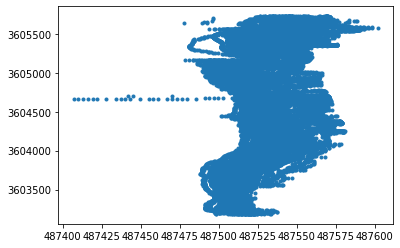

In [7]:

plt.plot(xS,yS,'.')

In [49]:
from sklearn.model_selection import train_test_split
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error 

def knotstring(kt_list):
    '''
    This function does xxx and returns yyy
    '''
    kt_string = str(kt_list[0])
    for i in kt_list[1:]:
        kt_string = kt_string + ',' + str(i)
    return kt_string


def CurrFilt(v,nf,ny,ford,btype):
    """
    filters data using set parameters.

    Parameters
    ----------
    v : array_like
        input signal
    nf : float
        filter cuttoff (units of time)
    ny : float
        Nyquist period (units of time)
    ford : int
        filter order
    btype : {‘lowpass’, ‘highpass’, ‘bandpass’, ‘bandstop’}, optional
        The type of filter. Default is ‘lowpass’.
        
    Returns
    -------
    vf : array_like
        filtered signal
    """
    from scipy import signal
    nynf = ny/nf
    b, a = signal.butter(ford, nynf, btype=btype)
    vf = signal.filtfilt(b, a, v)

    return vf

# Find nearest index value in numpy array
def find_nearest_index(array,value):
    idx = (np.abs(array-value)).idxmin()
    return idx

# Length between knots (m)
dyc = 1
Lkt = dyc*5

def Fit_Cubic_Spline(data_x, data_y,dx,Lkt):
    '''
    This function interpolates using cubic spline
    
    Parameters
    ----------
    data_x : array_like or list
             input signal (independent variable)
    data_y : array_like or list
             input signal (dependent variable)
    dx : float
         delta x (units of length)
    Lkt: float
         distance between knots
         
    Returns
    -------
    xp, yp : array_like
             filtered signal
    '''
    # Generating cubic spline
    deof = str(3)
    nresx = 1/dx
    
    xp = np.arange(data_x.min(), data_x.max(), nresx)
    
    # Dividing data into train and validation datasets
    train_x, valid_x, train_y, valid_y = train_test_split(data_x, data_y, test_size=0.2, random_state = 1)

    # Define spline knots
    # Number of knots (every Lkt m)
    Nkt = int((data_x.max()-data_x.min())/Lkt)
    kt = np.linspace(data_x.min(),data_x.max(),Nkt)
    kt = kt[1:-1]

    # convert knots from list to string
    kt_str = knotstring(kt)
    print("Number of knots: {}".format(Nkt-2))
    
    # Bin average the data in space using Regression splines (x, y): cubic spline
    # Generating cubic spline with X knots
    transformed_x = dmatrix("bs(train, knots=("+kt_str+"),degree ="+ deof+", include_intercept=False)", {"train": data_x}, return_type='dataframe')
    # Fitting Generalised linear model on transformed dataset
    fit = sm.GLM(data_y, transformed_x).fit()
    # Predictions on splines
    pred = fit.predict(dmatrix("bs(valid, knots=("+kt_str+"),degree ="+ deof+", include_intercept=False)", {"valid": data_x}, return_type='dataframe'))
    # Calculating RMSE values
    rmse = np.sqrt(mean_squared_error(data_y, pred))
    print("RMS for modified knot solution {}".format(rmse))
    # Make some predictions using splines
    yp = fit.predict(dmatrix("bs(xp, knots=("+kt_str+"),degree ="+ deof+", include_intercept=False)", {"xp": xp}, return_type='dataframe'))
    
    return xp,yp

    

Number of knots: 506
RMS for modified knot solution 13.611379848774297


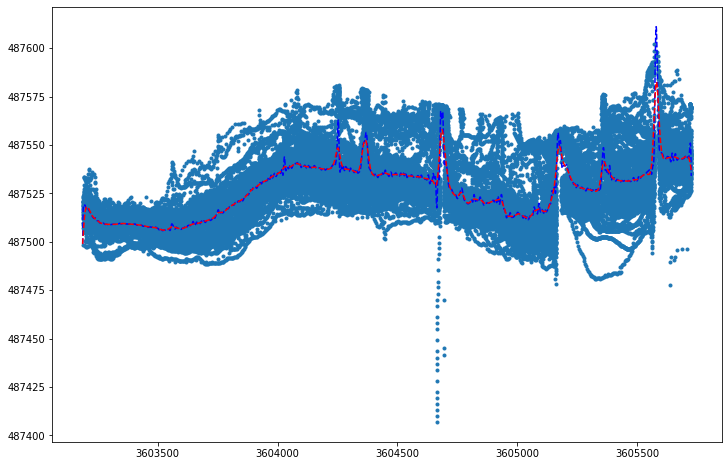

In [50]:
# Interpolate using cubic spline
data_x = yS
data_y = xS
dx = 1.0
Lkt = 5.0
yp,xp = Fit_Cubic_Spline(data_x,data_y,dx,Lkt)

# filter output
nf = Lkt*2
ny = dyc/2
ford = 2
btype = 'lowpass'
xpf = CurrFilt(xp,nf,ny,ford,btype='lowpass')


fig = plt.figure(figsize = (12, 8))
plt.plot(yS,xS,'.')
plt.plot(yp,xp,'--b')
plt.plot(yp,xpf,'--r')



In [51]:
# Calculate distance from spline

dS = []
for x,y in zip(xS,yS):
    d = np.sqrt((xp-x)**2 + (yp-y)**2)
    kk = find_nearest_index(d,0)
    
    dS.append(d[kk]*np.sign(x-xp[kk]))



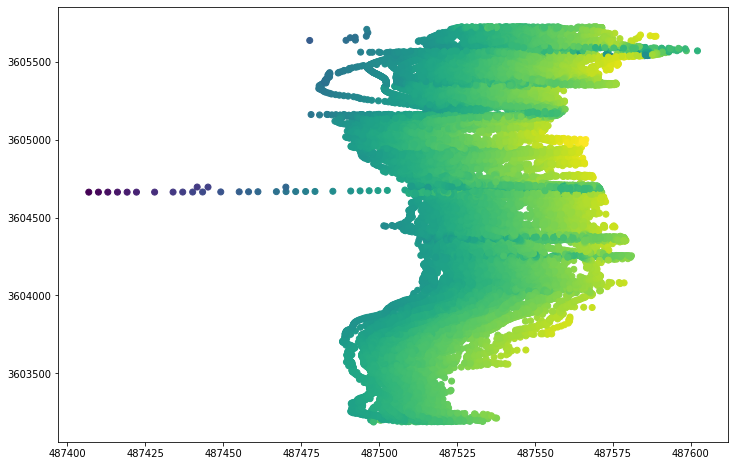

In [52]:

fig = plt.figure(figsize = (12, 8))
plt.scatter(xS,yS,c=dS)


/Users/andre/anaconda3/envs/bluetribe/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


-6.034587256793997

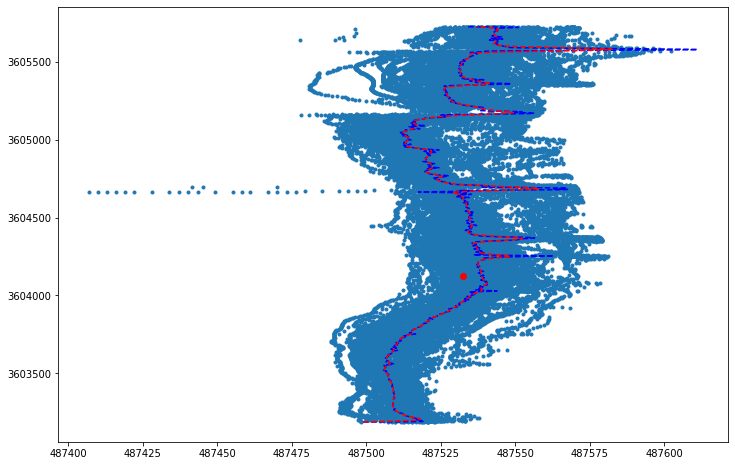

In [36]:
# Calculate distance from spline
# for x,y in zip(xS,yS):
    
d = np.sqrt((xp-xS[1050])**2 + (yp-yS[1050])**2)
kk = find_nearest_index(d,0)

fig = plt.figure(figsize = (12, 8))
plt.plot(xS,yS,'.')
plt.plot(xp,yp,'--b')
plt.plot(xpf,yp,'--r')
plt.plot(xS[1050],yS[1050],'or')

# plt.plot(yS,xS,'.')
# plt.plot(yp,xp,'--b')
# plt.plot(yp,xpf,'--r')
# plt.plot(yS[1050],xS[1050],'or')

d[kk]*np.sign(xS[1050]-xp[kk])
